# New models and developer products announced at DevDay

This is a notebook to test the new additions and improvements shared at the OpenAI DevDay on November 6, 2023.

The description of each text are from the blog post https://openai.com/blog/new-models-and-developer-products-announced-at-devday


In [4]:
from dotenv import load_dotenv
import os
import openai

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

# JSON mode

The new JSON mode ensures the model will respond with valid JSON. The new API parameter response_format enables the model to constrain its output to generate a syntactically correct JSON object. JSON mode is useful for developers generating JSON in the Chat Completions API outside of function calling.

In [20]:
import json

completion = openai.chat.completions.create(
  model="gpt-3.5-turbo-1106",
  response_format={"type": "json_object"},
  messages=[
    {"role": "system", "content": "Eres un asistente que siempre respone en formato JSON."},
    {"role": "user", "content": "Dame una lista de 7 lenguajes de programación. Llama a la lista 'lenguajes'"}
  ]
)

language_list = json.loads(completion.choices[0].message.content)
print(language_list)


{'lenguajes': ['Python', 'JavaScript', 'Java', 'C++', 'Ruby', 'PHP', 'Swift']}


# Reproducible outputs

The new seed parameter enables reproducible outputs by making the model return consistent completions most of the time. This beta feature is useful for use cases such as replaying requests for debugging, writing more comprehensive unit tests, and generally having a higher degree of control over the model behavior. OpenAI have been using this feature internally for their own unit tests and have found it invaluable.

In [21]:
async def get_gpt_response(sys_prompt, user_prompt, seed: int = None):
    try:
        completion = openai.chat.completions.create(
            model="gpt-3.5-turbo-1106",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": user_prompt},
            ],
            seed=seed,
            max_tokens=100,
            temperature=0.7,
        )

        response = completion.choices[0].message.content
        return response
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [22]:
sys_prompt = "Eres un asistente que escribe haikus."
user_prompt = "Escribe un haiku sobre las inteligencias artificiales."

SEED = 42
response_1 = await get_gpt_response(
    sys_prompt=sys_prompt, user_prompt=user_prompt, seed=SEED
)

response_2 = await get_gpt_response(
    sys_prompt=sys_prompt, user_prompt=user_prompt, seed=SEED
)


In [23]:
print("Haiku 1")
print(response_1)
print("\nHaiku 2")
print(response_2)

Haiku 1
Mentes sin cuerpo,
Código que piensa y crea,
Nuevos horizontes.

Haiku 2
Mentes sin cuerpo,
Código que piensa y crea,
Nuevos horizontes.


# DALL·E 3

Developers can integrate DALL·E 3 directly into their apps and products through our Images API by specifying dall-e-3 as the model. Companies like Snap, Coca-Cola, and Shutterstock have used DALL·E 3 to programmatically generate images and designs for their customers and campaigns. Similar to the previous version of DALL·E, the API incorporates built-in moderation to help developers protect their applications against misuse. The API offers different format and quality options, with prices starting at $0.04 per image generated.

In [24]:
response = openai.images.generate(
  model="dall-e-3",
  prompt= "un gato liderando una revolución rodeado de gatos",
  size="1024x1024",
  quality="standard",
  n=1,
)

image_url = response.data[0].url
image_url

'https://oaidalleapiprodscus.blob.core.windows.net/private/org-extsFsAiApK0EnmUkWV8VVr1/user-JOZJzNmBugERUKFMeKgPdznB/img-DkRbzvzIgh7syy9f8lhau88E.png?st=2023-11-07T22%3A04%3A13Z&se=2023-11-08T00%3A04%3A13Z&sp=r&sv=2021-08-06&sr=b&rscd=inline&rsct=image/png&skoid=6aaadede-4fb3-4698-a8f6-684d7786b067&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2023-11-07T19%3A14%3A32Z&ske=2023-11-08T19%3A14%3A32Z&sks=b&skv=2021-08-06&sig=r9Bn%2Bi9FWO%2BW2X/fru7MU1Ni3b07EjQ2OaAw6RMIKAE%3D'

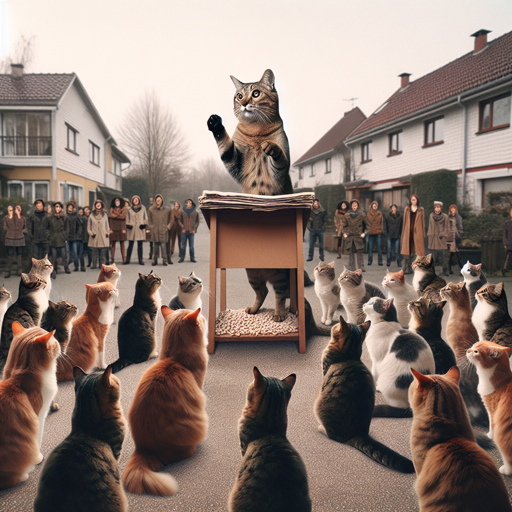

In [25]:
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display

# Retrieve the image from the URL
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

# Downsize the image to get a lower cost on the gpt-4-vision (next step)
width, height = img.size
img = img.resize((int(width/2), int(height/2)))

img.save("content/cats_revolution.png")

display(img)


# GPT-4 Turbo with vision

GPT-4 Turbo can accept images as inputs in the Chat Completions API, enabling use cases such as generating captions, analyzing real world images in detail, and reading documents with figures. For example, BeMyEyes uses this technology to help people who are blind or have low vision with daily tasks like identifying a product or navigating a store. Developers can access this feature by using gpt-4-vision-preview in the API. OpenAI plan to roll out vision support to the main GPT-4 Turbo model as part of its stable release. Pricing depends on the input image size. For instance, passing an image with 1080×1080 pixels to GPT-4 Turbo costs $0.00765.

In [28]:
import base64
import requests

image_path = "content/cats_revolution.png"
with open(image_path, "rb") as image_file:
    base64_image = base64.b64encode(image_file.read()).decode('utf-8')

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}"
}
payload = {
    "model": "gpt-4-vision-preview",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": "Cuenta una historia basada en esta imagen"
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          }
        ]
      }
    ],
    "max_tokens": 300
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

print(response.json())

{'id': 'chatcmpl-8IPbw20Raiz2RutxJojQ6XwQGLL7R', 'object': 'chat.completion', 'created': 1699399044, 'model': 'gpt-4-1106-vision-preview', 'usage': {'prompt_tokens': 271, 'completion_tokens': 300, 'total_tokens': 571}, 'choices': [{'message': {'role': 'assistant', 'content': 'En un tranquilo barrio residencial, algo extraordinario estaba teniendo lugar. Era una tarde brumosa cuando los felinos del vecindario, cansados de ser simples espectadores de la vida humana, decidieron que era hora de hacerse escuchar.\n\nEl gato más elocuente del grupo, conocido como Bigotes el Sabio, se puso sobre una caja de cartón improvisada como podio. Convocó a una asamblea de gatos, con la intención de discutir los problemas más acuciantes de su comunidad gatuna. La agenda era extensa: desde la calidad del pescado en sus comidas, la urgencia de más horas de caricias, hasta la distribución equitativa de los mejores lugares soleados para la siesta.\n\nMientras los humanos, desconcertados y cautivados, obser

In [29]:
story = response.json()['choices'][0]['message']['content']

print(story)

En un tranquilo barrio residencial, algo extraordinario estaba teniendo lugar. Era una tarde brumosa cuando los felinos del vecindario, cansados de ser simples espectadores de la vida humana, decidieron que era hora de hacerse escuchar.

El gato más elocuente del grupo, conocido como Bigotes el Sabio, se puso sobre una caja de cartón improvisada como podio. Convocó a una asamblea de gatos, con la intención de discutir los problemas más acuciantes de su comunidad gatuna. La agenda era extensa: desde la calidad del pescado en sus comidas, la urgencia de más horas de caricias, hasta la distribución equitativa de los mejores lugares soleados para la siesta.

Mientras los humanos, desconcertados y cautivados, observaban desde la distancia, los gatos escuchaban atentamente. Bigotes levantaba su pata, marcando el ritmo de su discurso con pasión y vigor. A medida que articulaba sus puntos, los miembros de la audiencia maullaban en señal de aprobación, erizando sus colas en entusiasmo.

Lo que 

# Text-to-speech (TTS)

Developers can now generate human-quality speech from text via the text-to-speech API. The new TTS model offers six preset voices to choose from and two model variants, tts-1 and tts-1-hd. tts is optimized for real-time use cases and tts-1-hd is optimized for quality. Pricing starts at $0.015 per input 1,000 characters.

In [35]:
from IPython.display import Audio
from pathlib import Path

response = client.audio.speech.create(
  model="tts-1",
  voice="shimmer",
  input=story
)

speech_file_path = Path('content/story.mp3')

with open(speech_file_path, 'wb') as file:
    file.write(response.content)

Audio(speech_file_path, autoplay=True)
